# Decision Trees and Ensemble Learning

This notebook covers:
- Decision Tree Training
- Visualization of a Decision Tree
- Voting Classifier
- Bagging and Boosting
- Random Forests

Dataset: Titanic (classification task)


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [36]:
# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
X = df[features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train and Visualize a Decision Tree

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       105
           1       0.84      0.64      0.72        74

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179



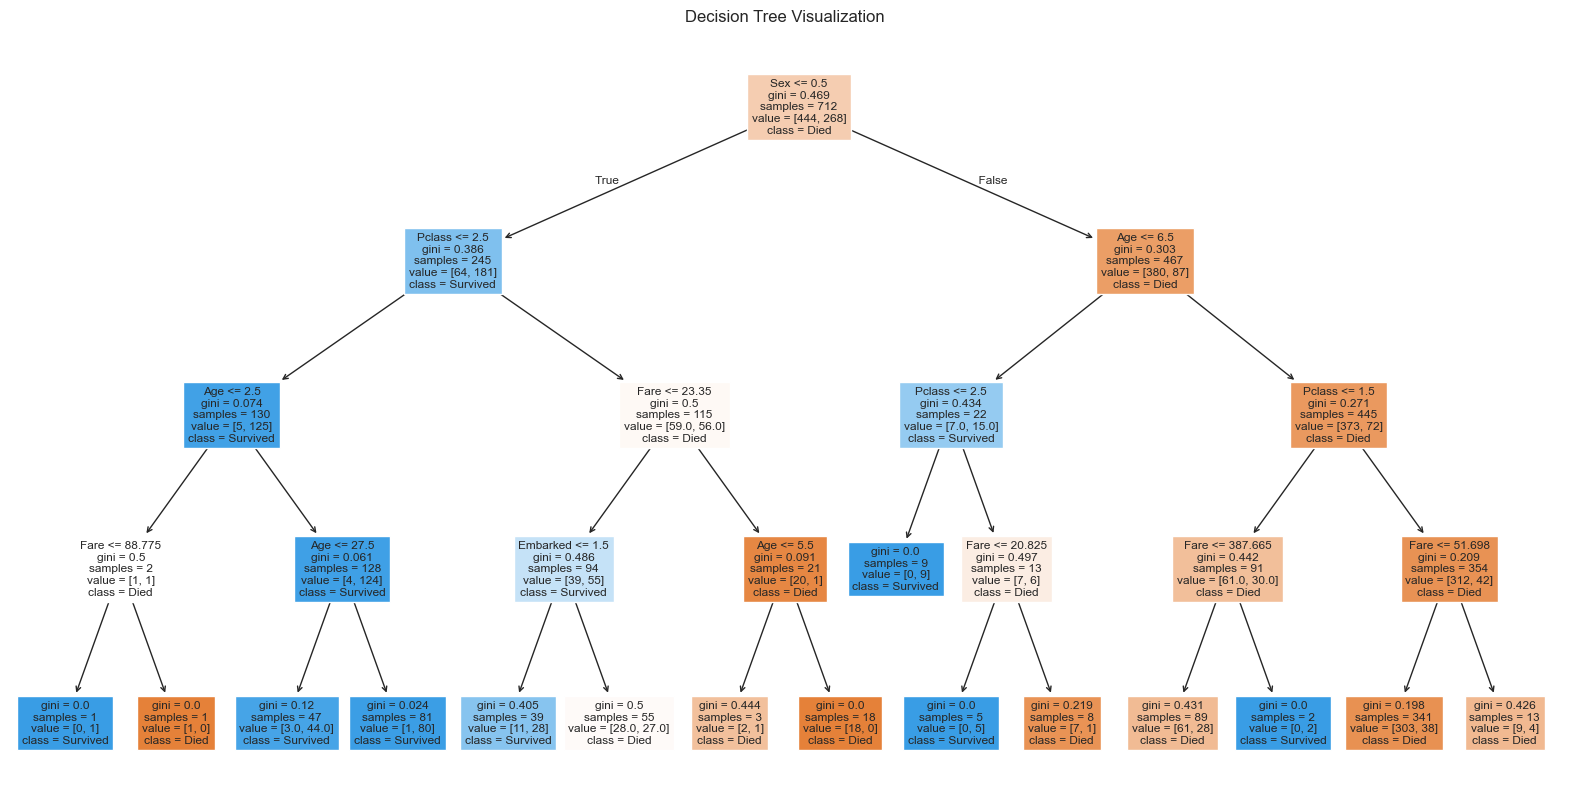

In [37]:
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print(classification_report(y_test, y_pred_tree))
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=features, class_names=['Died', 'Survived'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

## Hard Voting Classifier

In [38]:
voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('svc', SVC(probability=True)),
    ('dt', DecisionTreeClassifier())
], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred_vote))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84       105
           1       0.82      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179



## Random Forest

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       105
           1       0.75      0.73      0.74        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



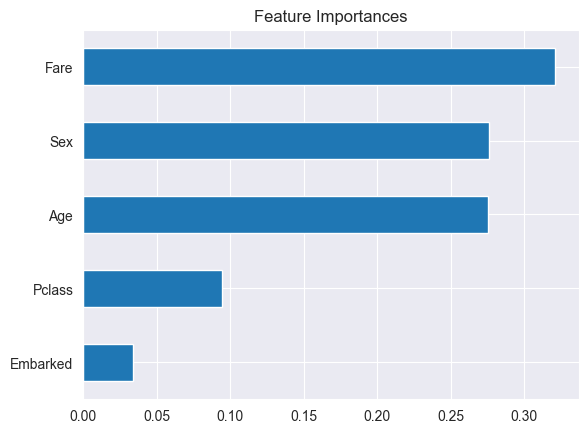

In [39]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)
print(classification_report(y_test, y_pred_forest))

importances = pd.Series(forest.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()


## Exercises

### 1. Try Different Depths for the Decision Tree
Try `max_depth` values of 2, 4, 6, and 10. What depth gives the best generalization?

```python
# Example:
for depth in [2, 4, 6, 10]:
...
```

---

### 2. Try Soft Voting Instead of Hard Voting
Change the `VotingClassifier` to use `voting='soft'` and compare accuracy.

---

### 3. Tune the Random Forest with GridSearchCV
Use `GridSearchCV` to find the best number of trees and max depth.

```python
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6, None]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
```


Testing different max_depth values...
Depth    2: CV=0.786±0.031, Test=0.765, Overfitting=0.038
Depth    4: CV=0.801±0.024, Test=0.799, Overfitting=0.040
Depth    6: CV=0.805±0.014, Test=0.799, Overfitting=0.063
Depth    8: CV=0.809±0.015, Test=0.810, Overfitting=0.073
Depth   10: CV=0.806±0.015, Test=0.804, Overfitting=0.097
Depth None: CV=0.794±0.021, Test=0.771, Overfitting=0.167

 DETAILED RESULTS:
   max_depth  cv_mean  cv_std  train_accuracy  test_accuracy  overfitting  \
0        2.0    0.786   0.031           0.803          0.765        0.038   
1        4.0    0.801   0.024           0.838          0.799        0.040   
2        6.0    0.805   0.014           0.862          0.799        0.063   
3        8.0    0.809   0.015           0.883          0.810        0.073   
4       10.0    0.806   0.015           0.902          0.804        0.097   
5        NaN    0.794   0.021           0.938          0.771        0.167   

   n_nodes  n_leaves  
0        7         4  
1       

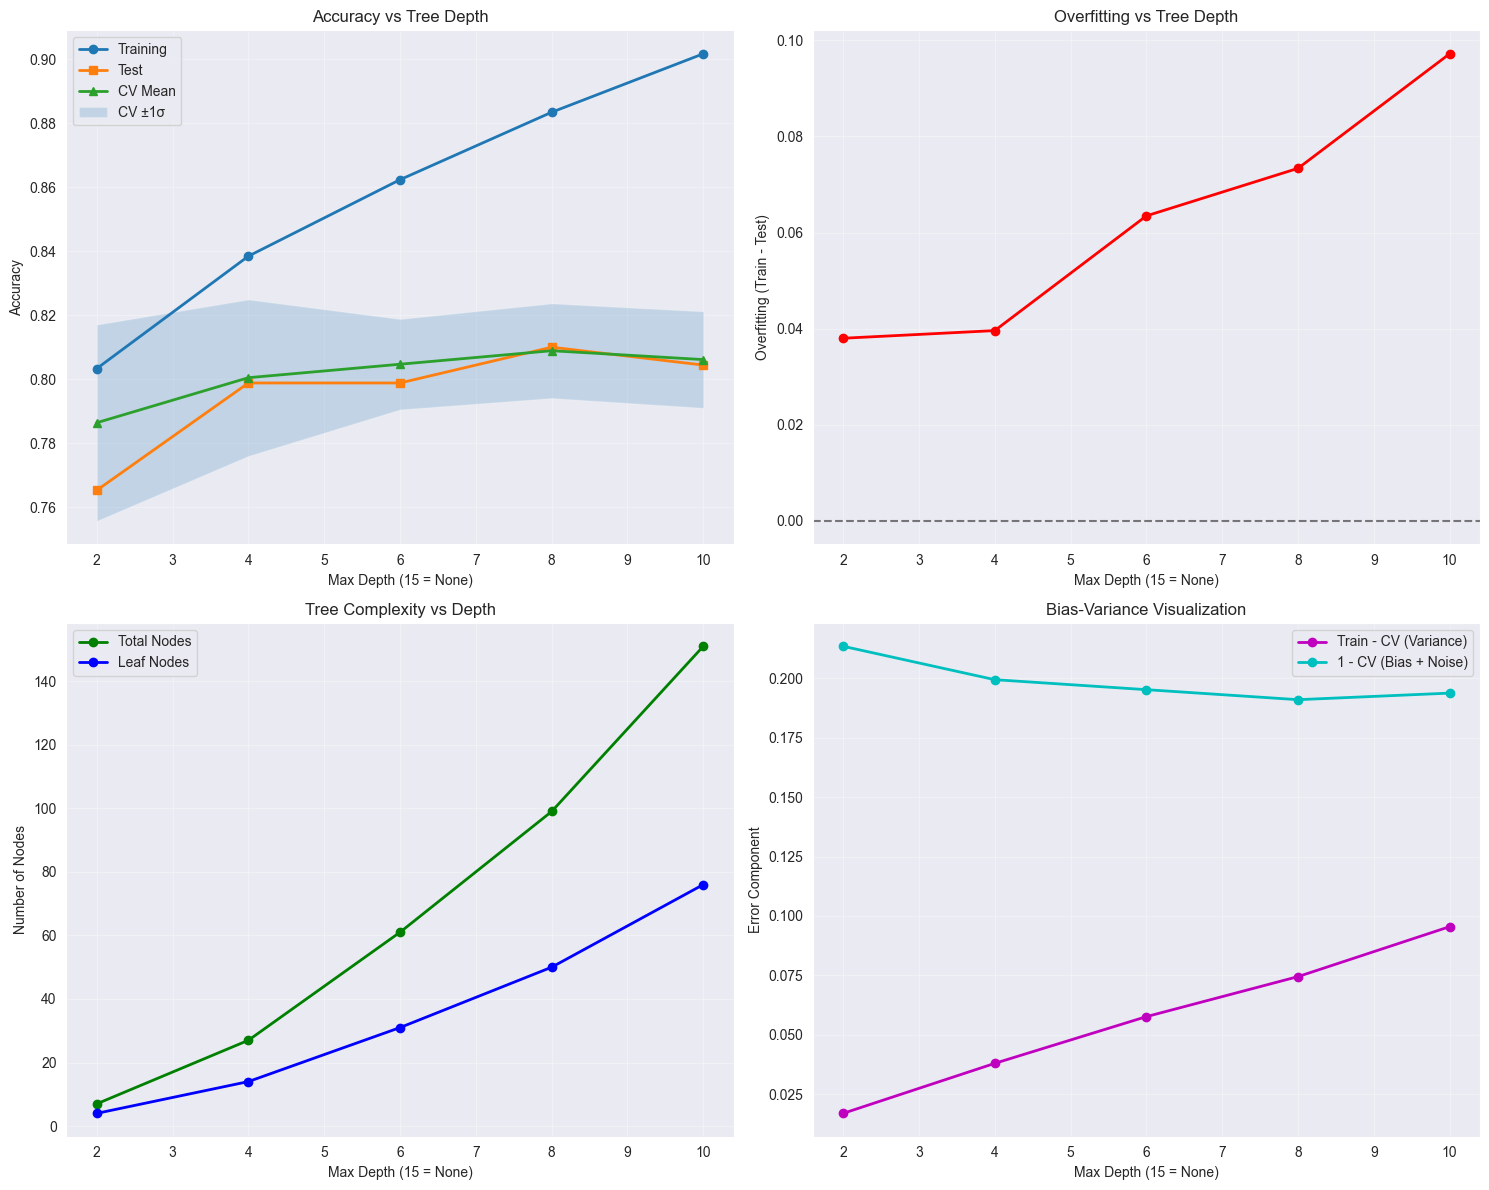


Use max_depth = 8.0


In [40]:
depths = [2, 4, 6, 8, 10, None]  # Added 8 and None for comprehensive analysis
results = []

print("Testing different max_depth values...")

for depth in depths:
    # Train decision tree with specific depth
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42, min_samples_split=5)

    # Use cross-validation for more robust evaluation
    cv_scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')

    # Train on full training set for test evaluation
    tree.fit(X_train, y_train)

    # Evaluate on test set
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)

    # Calculate overfitting metric
    overfitting = train_score - test_score

    results.append({
        'max_depth': depth,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_accuracy': train_score,
        'test_accuracy': test_score,
        'overfitting': overfitting,
        'n_nodes': tree.tree_.node_count,
        'n_leaves': tree.get_n_leaves()
    })

    depth_str = str(depth) if depth is not None else "None"
    print(f"Depth {depth_str:>4}: CV={cv_scores.mean():.3f}±{cv_scores.std():.3f}, "
          f"Test={test_score:.3f}, Overfitting={overfitting:.3f}")

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)
print(f"\n DETAILED RESULTS:")
print(results_df.round(3))

# Find optimal depth
best_cv_idx = results_df['cv_mean'].idxmax()
best_test_idx = results_df['test_accuracy'].idxmax()
min_overfit_idx = results_df['overfitting'].idxmin()

print(f"\n ANALYSIS:")
print(f"Best CV performance: max_depth = {results_df.loc[best_cv_idx, 'max_depth']} (CV: {results_df.loc[best_cv_idx, 'cv_mean']:.3f})")
print(f"Best test performance: max_depth = {results_df.loc[best_test_idx, 'max_depth']} (Test: {results_df.loc[best_test_idx, 'test_accuracy']:.3f})")
print(f"Least overfitting: max_depth = {results_df.loc[min_overfit_idx, 'max_depth']} (Overfitting: {results_df.loc[min_overfit_idx, 'overfitting']:.3f})")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Accuracy vs Depth
depths_plot = [d if d is not None else 15 for d in results_df['max_depth']]  # Use 15 for None
axes[0, 0].plot(depths_plot, results_df['train_accuracy'], 'o-', label='Training', linewidth=2)
axes[0, 0].plot(depths_plot, results_df['test_accuracy'], 's-', label='Test', linewidth=2)
axes[0, 0].plot(depths_plot, results_df['cv_mean'], '^-', label='CV Mean', linewidth=2)
axes[0, 0].fill_between(depths_plot,
                       results_df['cv_mean'] - results_df['cv_std'],
                       results_df['cv_mean'] + results_df['cv_std'],
                       alpha=0.2, label='CV ±1σ')
axes[0, 0].set_xlabel('Max Depth (15 = None)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs Tree Depth')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Overfitting vs Depth
axes[0, 1].plot(depths_plot, results_df['overfitting'], 'ro-', linewidth=2)
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Max Depth (15 = None)')
axes[0, 1].set_ylabel('Overfitting (Train - Test)')
axes[0, 1].set_title('Overfitting vs Tree Depth')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Tree Complexity
axes[1, 0].plot(depths_plot, results_df['n_nodes'], 'go-', label='Total Nodes', linewidth=2)
axes[1, 0].plot(depths_plot, results_df['n_leaves'], 'bo-', label='Leaf Nodes', linewidth=2)
axes[1, 0].set_xlabel('Max Depth (15 = None)')
axes[1, 0].set_ylabel('Number of Nodes')
axes[1, 0].set_title('Tree Complexity vs Depth')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Bias-Variance Trade-off Visualization
train_minus_cv = results_df['train_accuracy'] - results_df['cv_mean']
axes[1, 1].plot(depths_plot, train_minus_cv, 'mo-', label='Train - CV (Variance)', linewidth=2)
axes[1, 1].plot(depths_plot, 1 - results_df['cv_mean'], 'co-', label='1 - CV (Bias + Noise)', linewidth=2)
axes[1, 1].set_xlabel('Max Depth (15 = None)')
axes[1, 1].set_ylabel('Error Component')
axes[1, 1].set_title('Bias-Variance Visualization')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Max recommanded depth
optimal_depth = results_df.loc[best_cv_idx, 'max_depth']
print(f"\nUse max_depth = {optimal_depth}")


Individual Classifier Performance:
  LR : Train=0.794, Test=0.799, CV=0.786±0.024
  SVC: Train=0.669, Test=0.654, CV=0.663±0.015
  DT : Train=0.893, Test=0.793, CV=0.806±0.017

Hard Voting Classifier:
  Train=0.846, Test=0.810, CV=0.792±0.019

Soft Voting Classifier:
  Train=0.885, Test=0.821, CV=0.810±0.019

 VOTING COMPARISON:
                Hard Voting  Soft Voting  Improvement
Train Accuracy       0.8455       0.8848       0.0393
Test Accuracy        0.8101       0.8212       0.0112
CV Mean              0.7921       0.8103       0.0183
CV Std               0.0193       0.0188      -0.0005

Predictions differ in 6 out of 179 cases (3.4%)
Sample cases where predictions differ:
     Hard_Voting  Soft_Voting  Soft_Proba_0  Soft_Proba_1  Actual
70             0            1         0.499         0.501       0
512            0            1         0.435         0.565       1
78             0            1         0.423         0.577       1
97             1            0         0.534    

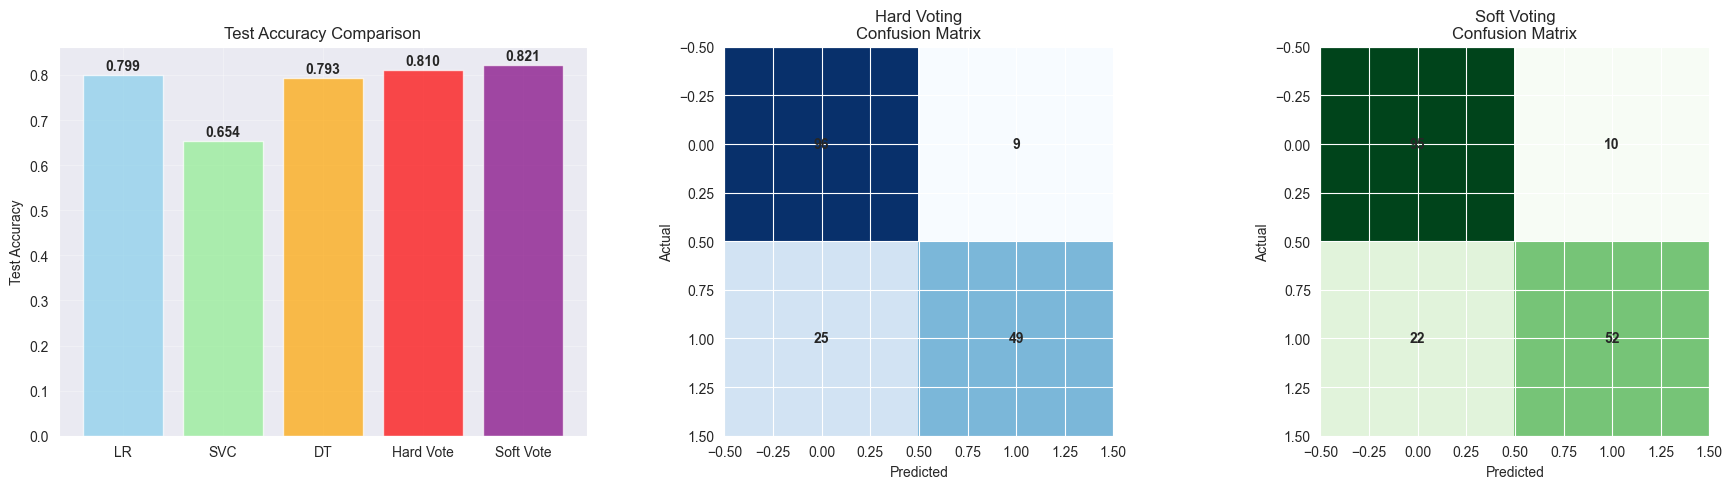

In [41]:
# Define base classifiers
base_classifiers = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),  # probability=True needed for soft voting
    ('dt', DecisionTreeClassifier(max_depth=np.int_(optimal_depth), random_state=42))
]

# Train individual classifiers for comparison
individual_results = {}
print("Individual Classifier Performance:")

for name, clf in base_classifiers:
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

    individual_results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"  {name.upper():3}: Train={train_acc:.3f}, Test={test_acc:.3f}, CV={cv_scores.mean():.3f}±{cv_scores.std():.3f}")

# Hard Voting Classifier
print(f"\nHard Voting Classifier:")
hard_voting_clf = VotingClassifier(estimators=base_classifiers, voting='hard')
hard_voting_clf.fit(X_train, y_train)

hard_train_acc = hard_voting_clf.score(X_train, y_train)
hard_test_acc = hard_voting_clf.score(X_test, y_test)
hard_cv_scores = cross_val_score(hard_voting_clf, X_train, y_train, cv=5, scoring='accuracy')

print(f"  Train={hard_train_acc:.3f}, Test={hard_test_acc:.3f}, CV={hard_cv_scores.mean():.3f}±{hard_cv_scores.std():.3f}")

# Soft Voting Classifier
print(f"\nSoft Voting Classifier:")
soft_voting_clf = VotingClassifier(estimators=base_classifiers, voting='soft')
soft_voting_clf.fit(X_train, y_train)

soft_train_acc = soft_voting_clf.score(X_train, y_train)
soft_test_acc = soft_voting_clf.score(X_test, y_test)
soft_cv_scores = cross_val_score(soft_voting_clf, X_train, y_train, cv=5, scoring='accuracy')

print(f"  Train={soft_train_acc:.3f}, Test={soft_test_acc:.3f}, CV={soft_cv_scores.mean():.3f}±{soft_cv_scores.std():.3f}")

# Detailed comparison
voting_comparison = pd.DataFrame({
    'Hard Voting': [hard_train_acc, hard_test_acc, hard_cv_scores.mean(), hard_cv_scores.std()],
    'Soft Voting': [soft_train_acc, soft_test_acc, soft_cv_scores.mean(), soft_cv_scores.std()],
    'Improvement': [soft_train_acc - hard_train_acc,
                   soft_test_acc - hard_test_acc,
                   soft_cv_scores.mean() - hard_cv_scores.mean(),
                   soft_cv_scores.std() - hard_cv_scores.std()]
}, index=['Train Accuracy', 'Test Accuracy', 'CV Mean', 'CV Std'])

print(f"\n VOTING COMPARISON:")
print(voting_comparison.round(4))

# Get prediction probabilities for analysis
hard_pred = hard_voting_clf.predict(X_test)
soft_pred = soft_voting_clf.predict(X_test)
soft_proba = soft_voting_clf.predict_proba(X_test)

# Compare predictions
prediction_comparison = pd.DataFrame({
    'Hard_Voting': hard_pred,
    'Soft_Voting': soft_pred,
    'Soft_Proba_0': soft_proba[:, 0],
    'Soft_Proba_1': soft_proba[:, 1],
    'Actual': y_test
})

# Cases where predictions differ
different_predictions = prediction_comparison[prediction_comparison['Hard_Voting'] != prediction_comparison['Soft_Voting']]
print(f"\nPredictions differ in {len(different_predictions)} out of {len(y_test)} cases ({len(different_predictions)/len(y_test):.1%})")

if len(different_predictions) > 0:
    print("Sample cases where predictions differ:")
    print(different_predictions.head().round(3))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Accuracy comparison
methods = ['LR', 'SVC', 'DT', 'Hard Vote', 'Soft Vote']
test_accs = [individual_results['lr']['test_accuracy'],
             individual_results['svc']['test_accuracy'],
             individual_results['dt']['test_accuracy'],
             hard_test_acc, soft_test_acc]

bars = axes[0].bar(methods, test_accs, color=['skyblue', 'lightgreen', 'orange', 'red', 'purple'], alpha=0.7)
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, test_accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Confusion matrices
from sklearn.metrics import confusion_matrix

cm_hard = confusion_matrix(y_test, hard_pred)
cm_soft = confusion_matrix(y_test, soft_pred)

im1 = axes[1].imshow(cm_hard, cmap='Blues')
axes[1].set_title('Hard Voting\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Add text annotations
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, str(cm_hard[i, j]), ha='center', va='center', fontweight='bold')

im2 = axes[2].imshow(cm_soft, cmap='Greens')
axes[2].set_title('Soft Voting\nConfusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

# Add text annotations
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, str(cm_soft[i, j]), ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Parameter grid:
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 7, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]

Total combinations: 324
Using simplified grid with 36 combinations for faster execution...

Performing GridSearchCV (this may take a while)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

🏆 BEST PARAMETERS:
  max_depth: 6
  max_features: sqrt
  min_samples_split: 5
  n_estimators: 50

Best CV Score: 0.8399
Test Score: 0.8045

📊 IMPROVEMENT ANALYSIS:
Default Random Forest test score: 0.7877
Tuned Random Forest test score:   0.8045
Improvement: 0.0168 (2.1%)

🎯 FEATURE IMPORTANCE (Tuned Model):
Sex         0.4281
Fare        0.2267
Age         0.1633
Pclass      0.1405
Embarked    0.0414
dtype: float64


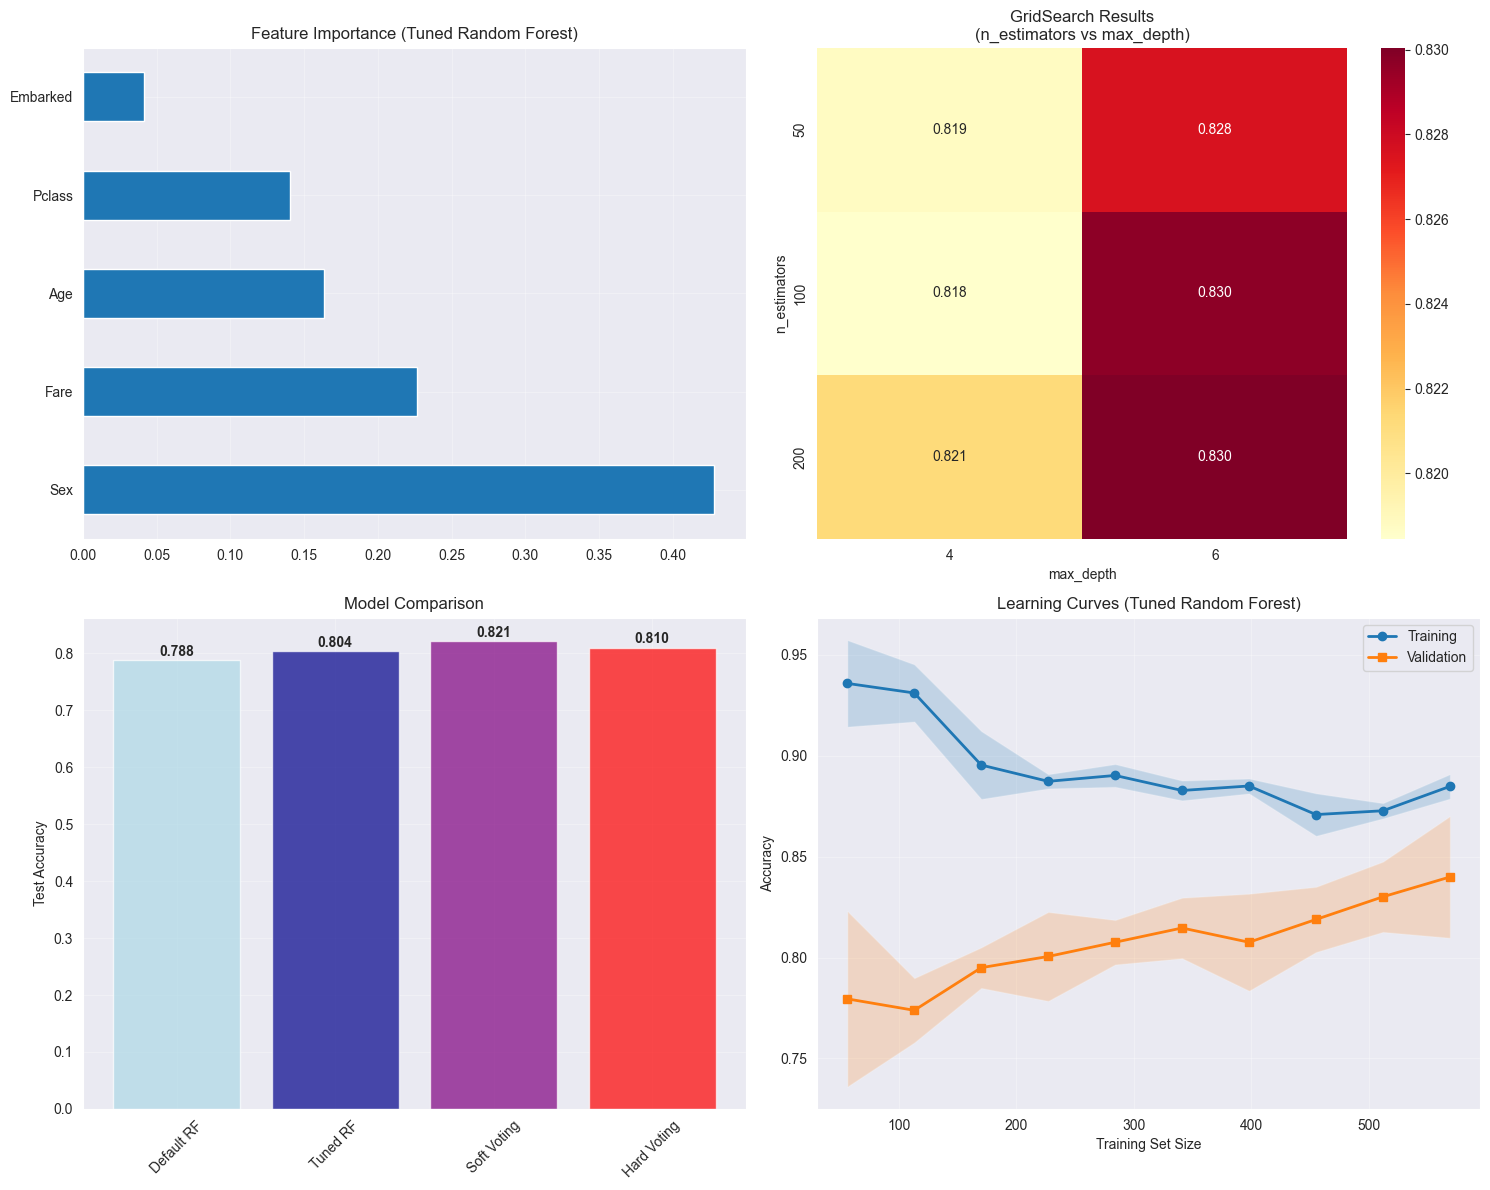

In [43]:

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {np.prod([len(v) for v in param_grid.values()])}")

# Simplified grid for faster execution (you can use the full grid if you have time)
param_grid_simplified = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', None]
}

print(f"Using simplified grid with {np.prod([len(v) for v in param_grid_simplified.values()])} combinations for faster execution...")

# Perform GridSearch
print("\nPerforming GridSearchCV (this may take a while)...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_simplified,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all cores for faster computation
    verbose=1
)

grid_search.fit(X_train, y_train)

# Results
print(f"\n🏆 BEST PARAMETERS:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_rf = grid_search.best_estimator_
test_score = best_rf.score(X_test, y_test)
print(f"Test Score: {test_score:.4f}")

# Compare with default Random Forest
default_rf = RandomForestClassifier(random_state=42)
default_rf.fit(X_train, y_train)
default_test_score = default_rf.score(X_test, y_test)

print(f"\n📊 IMPROVEMENT ANALYSIS:")
print(f"Default Random Forest test score: {default_test_score:.4f}")
print(f"Tuned Random Forest test score:   {test_score:.4f}")
print(f"Improvement: {test_score - default_test_score:.4f} ({(test_score - default_test_score)/default_test_score*100:.1f}%)")

# Feature importance comparison
print(f"\n🎯 FEATURE IMPORTANCE (Tuned Model):")
feature_importance = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
print(feature_importance.round(4))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Feature importance
feature_importance.plot(kind='barh', ax=axes[0, 0])
axes[0, 0].set_title('Feature Importance (Tuned Random Forest)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: GridSearch results heatmap (for n_estimators vs max_depth)
results_df = pd.DataFrame(grid_search.cv_results_)

# Create pivot table for heatmap
pivot_data = results_df.groupby(['param_n_estimators', 'param_max_depth'])['mean_test_score'].mean().unstack()
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0, 1])
axes[0, 1].set_title('GridSearch Results\n(n_estimators vs max_depth)')
axes[0, 1].set_xlabel('max_depth')
axes[0, 1].set_ylabel('n_estimators')

# Plot 3: Model comparison
models = ['Default RF', 'Tuned RF', 'Soft Voting', 'Hard Voting']
scores = [default_test_score, test_score, soft_test_acc, hard_test_acc]

bars = axes[1, 0].bar(models, scores, color=['lightblue', 'darkblue', 'purple', 'red'], alpha=0.7)
axes[1, 0].set_ylabel('Test Accuracy')
axes[1, 0].set_title('Model Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Add value labels
for bar, score in zip(bars, scores):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                   f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Learning curves for best model
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

axes[1, 1].plot(train_sizes, train_mean, 'o-', label='Training', linewidth=2)
axes[1, 1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
axes[1, 1].plot(train_sizes, val_mean, 's-', label='Validation', linewidth=2)
axes[1, 1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
axes[1, 1].set_xlabel('Training Set Size')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Learning Curves (Tuned Random Forest)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()